In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.20.3
astropy: 4.3.1


In [498]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

from copy import copy

In [86]:
from astropy.io import fits

To open the fits file we use `fits.open()` and just specify the filename as an argument:

In [5]:
fits_file = fits.open('../1_read_data/data_test/run_05029747_DL3.fits')

We can retrieve some basic information on the  header data unit (HDU) by calling `.info()`:

In [6]:
fits_file.info()

Filename: ../1_read_data/data_test/run_05029747_DL3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  EVENTS        1 BinTableHDU     59   6310R x 5C   [1K, 1D, 1E, 1E, 1E]   
  2  GTI           1 BinTableHDU     24   1R x 2C   [1D, 1D]   
  3  EFFECTIVE AREA    1 BinTableHDU     37   1R x 5C   [21E, 21E, 2E, 2E, 42E]   
  4  ENERGY DISPERSION    1 BinTableHDU     37   1R x 7C   [20E, 20E, 80E, 80E, 2E, 2E, 3200E]   


### Events

In [241]:
events = fits_file['EVENTS']

In [242]:
events.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   28 / width of table in bytes                        
NAXIS2  =                 6310 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'EVENT_ID'           / label for field   1                            
TFORM1  = '1K      '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'TIME    '           / label for field   2                            
TFORM2  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT2  = 's       '        

### PLOT SOURCE, POINTING and ON and OFF REGIONS

In [428]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

In [429]:
wcs = WCS(events.header)

a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 56569.000000 from DATE-OBS.
Set MJD-END to 56569.000000 from DATE-END'. [astropy.wcs.wcs]


In [430]:
pointing_pos =  SkyCoord( events.header.get('RA_PNT') *u.deg,   events.header.get('DEC_PNT') *u.deg )
source_pos   =  SkyCoord.from_name(events.header.get('OBJECT'))

In [457]:
offset = source_pos.separation(pointing_pos)
offset.to( u.deg).value

0.39727511625478695

In [447]:
# angle position of the source relative to the pointing
source_angle = pointing_pos.position_angle(source_pos).to(u.degree)
off1_angle   = source_angle + 90*u.deg
off2_angle   = off1_angle   + 90*u.deg
off3_angle   = off2_angle   + 90*u.deg

In [448]:
off1_pos = pointing_pos.directional_offset_by(position_angle=off1_angle, separation=offset)  
off2_pos = pointing_pos.directional_offset_by(position_angle=off2_angle, separation=offset)  
off3_pos = pointing_pos.directional_offset_by(position_angle=off3_angle, separation=offset)  

In [770]:
radius = offset/np.sqrt(2)
radius /=2

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

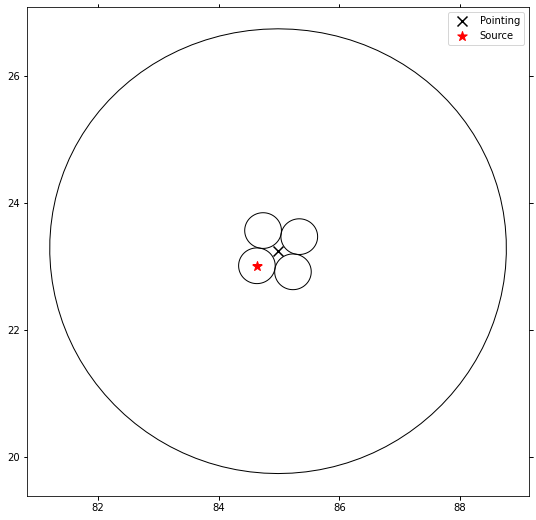

In [530]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot(projection=wcs)


field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(field_of_view)

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)

ax.legend();

### PLOT AZIMUTH AND ALTITUDE DURING THE OBSERVATION

In [481]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time

In [482]:
ROM = EarthLocation( lat=events.header.get('GEOLAT')* u.deg, 
              lon=events.header.get('GEOLON') * u.deg, 
              height= events.header.get('ALTITUDE')*u.m)
print(ROM)

(5326845.71658856, -1719569.6479979, 3051841.96403305) m


In [483]:
events.header.get('DATE-OBS') +'T'+events.header.get('TIME-OBS')

'2013-10-04T04:20:46'

In [484]:
start_time = Time( events.header.get('DATE-OBS') +'T'+events.header.get('TIME-OBS')) 
end_time   = Time( events.header.get('DATE-END') +'T'+events.header.get('TIME-END')) 

In [485]:
dt = ( end_time - start_time ) /100
times        = []
source_altaz = []
for i in range(100):
    time        = start_time + dt*i
    altaz        = AltAz(obstime=time, location=ROM)
    i_source_altaz = source_pos.transform_to(altaz)
    times.append( time )
    source_altaz.append( i_source_altaz )
    

In [486]:
all_alt = [  i.alt.value for i in source_altaz ]
all_az  = [  i.az.value  for i in source_altaz ]

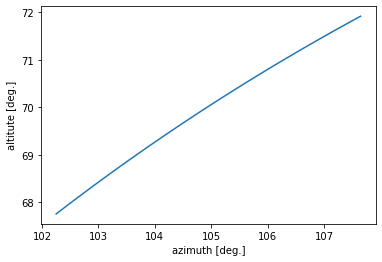

In [487]:
plt.plot(  all_az, all_alt)
plt.xlabel( "azimuth [deg.]")
plt.ylabel( "altitute [deg.]");

## GET EVENTS

In [488]:
events_table = Table( events.data )
events_table

EVENT_ID,TIME,RA,DEC,ENERGY
int64,float64,float32,float32,float32
42,333778849.5267153,444.21463,23.44914,0.08397394
67,333778849.61315054,443.5247,22.725792,0.10596932
80,333778849.6690142,443.76956,22.451006,0.19733498
116,333778849.7778549,443.71518,21.985115,1.0020943
179,333778849.9826064,443.64136,22.041315,0.10316629
198,333778850.0339344,444.84238,22.175398,0.118843034
251,333778850.20117164,442.21805,21.617695,0.2293238
299,333778850.3477573,443.1049,22.165325,0.13139088
323,333778850.42124623,444.23206,22.624523,0.12255095


In [759]:
radius = offset/np.sqrt(2)
radius /=2

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

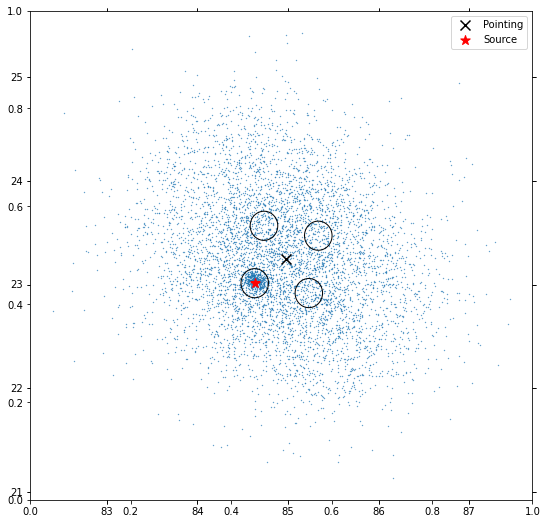

In [760]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot(projection=wcs)

ra = events_table['RA'] - 360
dec = events_table['DEC']
ax.scatter(ra, dec, s=0.1)


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 


ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)

ax.legend();

In [761]:
ra = events_table['RA'] 
dec = events_table['DEC']

cond_on = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_on.append( source_pos.separation(position_event) < radius )
    
cond_off1 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off1.append( off1_pos.separation(position_event) < radius )
    
cond_off2 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off2.append( off2_pos.separation(position_event) < radius )
    

cond_off3 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off3.append( off3_pos.separation(position_event) < radius )

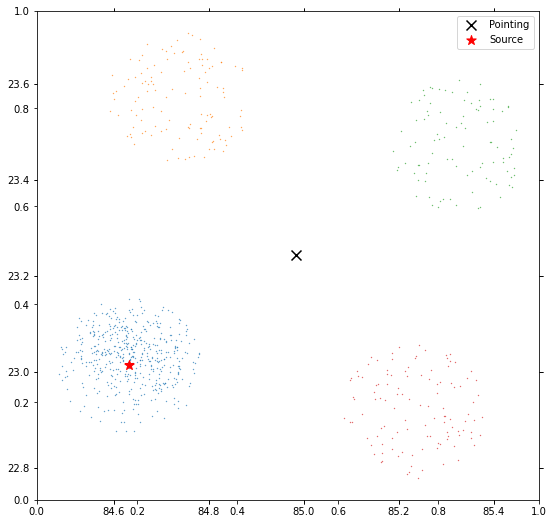

In [762]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot(projection=wcs)

ra = events_table[cond_on]['RA'] - 360
dec = events_table[cond_on]['DEC']
ax.scatter(ra, dec, s=0.1)

ra = events_table[cond_off1]['RA'] - 360
dec = events_table[cond_off1]['DEC']
ax.scatter(ra, dec, s=0.1)

ra = events_table[cond_off2]['RA'] - 360
dec = events_table[cond_off2]['DEC']
ax.scatter(ra, dec, s=0.1)

ra = events_table[cond_off3]['RA'] - 360
dec = events_table[cond_off3]['DEC']
ax.scatter(ra, dec, s=0.1)


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 



ax.legend();

### Effective Area

In [745]:
effective_area = fits_file['EFFECTIVE AREA']

In [746]:
effective_area.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  352 / width of table in bytes                        
NAXIS2  =                    1 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'ENERG_LO'           / label for field   1                            
TFORM1  = '21E     '           / data format of field: 4-byte REAL              
TUNIT1  = 'TeV     '           / physical unit of field                         
TTYPE2  = 'ENERG_HI'           / label for field   2                            
TFORM2  = '21E     '        

In [747]:
effective_area = Table( effective_area.data)

In [748]:
theta_low  = np.array( effective_area['THETA_LO'] )[0]
theta_high = np.array( effective_area['THETA_HI'] )[0]

en_low     = np.array( effective_area['ENERG_LO'] )[0]
en_high    = np.array( effective_area['ENERG_HI'] )[0]
en_center = np.sqrt( en_low * en_high )
delta_E  = (en_high - en_low) * u.TeV

eff_area   = np.array( effective_area['EFFAREA'] )[0][0]



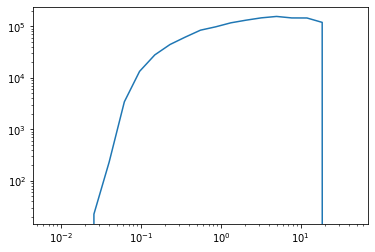

In [749]:
plt.plot(en_center,  eff_area)
plt.xscale('log')
plt.yscale('log')

In [763]:
# REMOVE BIN WITH EFF AREA = 0
cond = eff_area >0
en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

### COMPUTE EXCESS

In [764]:
excess = [] 
err_excess = []
for i_en_low, i_en_high in zip( en_low, en_high):
    cond_low  = events_table['ENERGY'] >= i_en_low
    cond_high = events_table['ENERGY']  < i_en_high
    cond_en   = cond_low* cond_high
    
    non    = np.sum( cond_en*cond_on)
    
    noff   = np.sum( cond_en*cond_off1) +\
             np.sum( cond_en*cond_off2) +\
             np.sum( cond_en*cond_off3)
    
    excess.append( non - noff/3 )
    err_excess.append( np.sqrt( non + (1/3)**2*noff) )
    
excess     = np.array(excess)
err_excess = np.array(err_excess)

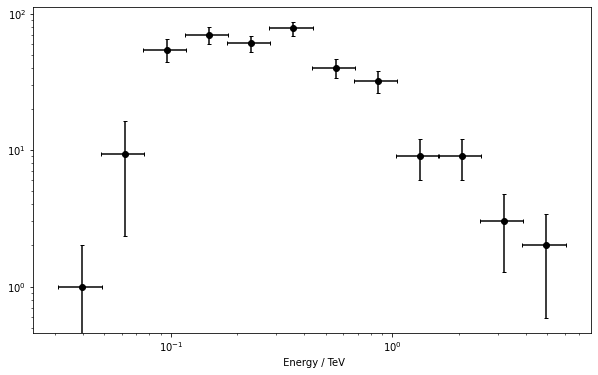

In [771]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, y=excess, yerr=err_excess , xerr = delta_E.value/2 , c='black', capsize=2, fmt='o')

ax.set_xlabel( ' Energy / TeV')
ax.set_xscale('log')
ax.set_yscale('log')

In [766]:
# REMOVE BIN WITH NEGATIVE OR ZERO EXCESS
cond = excess >0
en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

excess     = excess[cond]
err_excess = err_excess[cond]

### COMPUTE FLUX

In [767]:
exposure_time = events.header.get('LIVETIME') * u.second 
exposure_time.to( u.minute)

<Quantity 19.67830828 min>

In [768]:
def log_parababola( e, f0, E0, a, b):
    return f0* (e/E0) **( - a + b* np.log( e/E0))

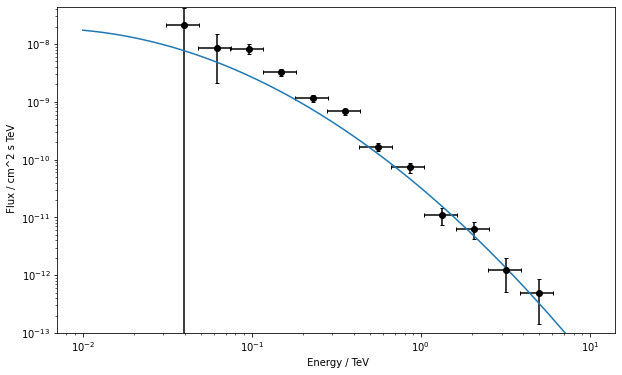

In [772]:
flux = excess/( eff_area * u.m**2)/ exposure_time/ delta_E

flux_err = err_excess/( eff_area * u.m**2)/ exposure_time/ delta_E




fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=new_en_center, 
            y=flux.to( 1/(u.TeV * u.cm**2 * u.s) ).value, 
            yerr = flux_err.to( 1/(u.TeV * u.cm**2 * u.s) ).value , 
            xerr = delta_E.value/2 , c='black', capsize=2, fmt='o')

x = np.logspace(-2,1,1000) * u.TeV
f0 = 3.23e-11 * 1/(u.TeV * u.cm**2 * u.s)
E0 = 1 * u.TeV
a  = 2.47
b  = -0.24
y = log_parababola(x, f0, E0, a, b)

ax.plot(x,y)

ax.set_ylim([1e-13, None])

ax.set_xlabel( ' Energy / TeV')

ax.set_ylabel( ' Flux / cm^2 s TeV')
ax.set_xscale('log')
ax.set_yscale('log')